## HW6 Temperature Prediction 2

**Author:** Alvin B. Lin\
**Date:** 08/10/2025\
**HW Number:** 6\
\
*Special Credit to my reliable partners: ChatGPT and Gemini.*

---

### Problem 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import re 
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

Importing necessary packages for the analysis.

In [2]:
# --- CELL 1: 數據常量和定義 ---

LON_START = 120.00
LAT_START = 21.88
RESOLUTION = 0.03
LON_COUNT = 67
LAT_COUNT = 120
TOTAL_POINTS = LON_COUNT * LAT_COUNT 
INVALID_VALUE = -999.0
XML_FILE_PATH = "C:\\Users\\benny\\Documents\\ML\\HW6\\temp_data.xml"

Locate the file for the further reading.

In [3]:
# --- CELL 2: 數據讀取與解析函數 ---

def read_and_parse_xml(file_path):
    """
    Reads the XML file and extracts temperature data.
    """
    print("--- DATA LOADING AND COORDINATE GENERATION ---")
    GRID_LAT_SIZE = LAT_COUNT
    GRID_LON_SIZE = LON_COUNT
    
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
        content_element = next((elem for elem in root.iter() if elem.tag.lower().endswith('content')), None)

        if content_element is None or content_element.text is None:
            raise ValueError("Could not find Content element or it is empty.")

        content_str = content_element.text
        number_strings = re.findall(r'[-+]?\d*\.?\d+(?:[Ee][-+]?\d+)?', content_str)
        values = np.array([float(x) for x in number_strings if x], dtype=np.float64)

        expected_count = GRID_LAT_SIZE * GRID_LON_SIZE
        if values.size != expected_count:
            raise ValueError(f"Parsed {values.size} numeric values but expected {expected_count}")

        grid = values.reshape((GRID_LAT_SIZE, GRID_LON_SIZE))

        print(f"Data loaded successfully. Grid shape: {grid.shape}")
        return grid

    except FileNotFoundError:
        print(f"Error: XML file not found at {file_path}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"XML Parsing or Data Processing Failed: {e}", file=sys.stderr)
        return None

def create_classification_dataset(temp_grid):
    """
    Converts the temperature grid into the classification dataset: (Longitude, Latitude, label).
    """
    print("\n--- CLASSIFICATION DATASET CREATION ---")
    lat_count, lon_count = temp_grid.shape
    
    lon_coords = LON_START + np.arange(lon_count) * RESOLUTION
    lat_coords = LAT_START + np.arange(lat_count) * RESOLUTION
    
    Lon_grid, Lat_grid = np.meshgrid(lon_coords, lat_coords)
    X = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
    
    Y = (temp_grid.ravel() != INVALID_VALUE).astype(int)
    
    print(f"Classification features (X) shape: {X.shape}")
    print(f"Valid points (Y=1): {np.sum(Y)}, Invalid points (Y=0): {np.sum(Y==0)}")
    return X, Y

Define a function to read the file.

In [4]:
# --- CELL 3: LDA 和 QDA 類別定義 (GDA 變體) ---

class LinearDiscriminantAnalysis:
    """Implements LDA (GDA with shared covariance), representing the initial "failed" model."""
    def __init__(self):
        self.phi = 0.0
        self.mu0 = None
        self.mu1 = None
        self.sigma_inv = None
        self.discriminant_weights = None
        self.discriminant_bias = None

    def fit(self, X, Y):
        m = X.shape[0] 
        Y0 = X[Y == 0] 
        Y1 = X[Y == 1]
        m1 = Y1.shape[0]
        self.phi = m1 / m
        self.mu0 = np.mean(Y0, axis=0)
        self.mu1 = np.mean(Y1, axis=0)
        
        Sigma0 = (Y0 - self.mu0).T @ (Y0 - self.mu0)
        Sigma1 = (Y1 - self.mu1).T @ (Y1 - self.mu1)
        sigma = (Sigma0 + Sigma1) / m
        sigma += np.eye(sigma.shape[0]) * 1e-6 
        self.sigma_inv = np.linalg.inv(sigma)
        
        self.discriminant_weights = self.sigma_inv @ (self.mu1 - self.mu0)
        self.discriminant_bias = 0.5 * (self.mu0.T @ self.sigma_inv @ self.mu0 - self.mu1.T @ self.sigma_inv @ self.mu1) + np.log(self.phi / (1 - self.phi))
        
    def predict_proba(self, X):
        score = X @ self.discriminant_weights + self.discriminant_bias
        return 1 / (1 + np.exp(-score))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

class QuadraticDiscriminantAnalysis:
    """Implements QDA (GDA with separate covariance matrices) - The optimized model."""
    def __init__(self):
        self.phi = 0.0
        self.mu0 = None
        self.mu1 = None
        self.sigma0_inv = None
        self.sigma1_inv = None
        self.sigma0_det = None
        self.sigma1_det = None

    def fit(self, X, Y):
        m = X.shape[0]
        Y0 = X[Y == 0] 
        Y1 = X[Y == 1]
        m0 = Y0.shape[0]
        m1 = Y1.shape[0]
        self.phi = m1 / m
        self.mu0 = np.mean(Y0, axis=0)
        self.mu1 = np.mean(Y1, axis=0)

        Sigma0 = (Y0 - self.mu0).T @ (Y0 - self.mu0) / m0
        Sigma1 = (Y1 - self.mu1).T @ (Y1 - self.mu1) / m1
        
        Sigma0 += np.eye(Sigma0.shape[0]) * 1e-6
        Sigma1 += np.eye(Sigma1.shape[0]) * 1e-6

        self.sigma0_inv = np.linalg.inv(Sigma0)
        self.sigma1_inv = np.linalg.inv(Sigma1)
        self.sigma0_det = np.linalg.det(Sigma0)
        self.sigma1_det = np.linalg.det(Sigma1)

    def predict_proba(self, X):
        diff0 = X - self.mu0
        log_likelihood0 = -0.5 * np.log(self.sigma0_det) - 0.5 * np.sum(diff0 @ self.sigma0_inv * diff0, axis=1)
        
        diff1 = X - self.mu1
        log_likelihood1 = -0.5 * np.log(self.sigma1_det) - 0.5 * np.sum(diff1 @ self.sigma1_inv * diff1, axis=1)
        
        log_joint0 = log_likelihood0 + np.log(1 - self.phi)
        log_joint1 = log_likelihood1 + np.log(self.phi)
        
        return 1 / (1 + np.exp(log_joint0 - log_joint1))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

Define the *class* for both **GDA** and **QDA**.

In [5]:
# --- CELL 4: 邏輯迴歸類別定義 (Loss Curve 專用) ---

class LogisticRegressionGD:
    """Implements Logistic Regression using Gradient Descent."""
    def __init__(self, learning_rate=0.1, n_iterations=500):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []
        self.val_loss_history = [] # 新增：用於儲存驗證集 Loss

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500) 
        return 1.0 / (1.0 + np.exp(-z))

    def _loss(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Binary Cross-Entropy (Log Loss)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    # 更新 fit 函式，接受訓練集 (X_train, Y_train) 和 驗證集 (X_val, Y_val)
    def fit(self, X_train, Y_train, X_val=None, Y_val=None):
        n_samples, n_features = X_train.shape
        self.weights = np.zeros(n_features) * 1e-3
        self.bias = 0
        self.loss_history = []
        self.val_loss_history = []

        for i in range(self.n_iterations):
            # 1. 訓練集 Loss 計算和梯度下降
            z_train = np.dot(X_train, self.weights) + self.bias
            y_pred_train = self._sigmoid(z_train)

            current_train_loss = self._loss(Y_train, y_pred_train)
            self.loss_history.append(current_train_loss)
            
            # 2. 驗證集 Loss 計算 (如果提供了驗證集)
            if X_val is not None and Y_val is not None:
                z_val = np.dot(X_val, self.weights) + self.bias
                y_pred_val = self._sigmoid(z_val)
                current_val_loss = self._loss(Y_val, y_pred_val)
                self.val_loss_history.append(current_val_loss)
            
            # 3. 梯度更新 (僅基於訓練集)
            dw = (1 / n_samples) * np.dot(X_train.T, (y_pred_train - Y_train))
            db = (1 / n_samples) * np.sum(y_pred_train - Y_train)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # 4. 打印 Loss 進度
            if (i + 1) % (self.n_iterations // 5 or 1) == 0:
                val_loss_msg = f", Test Loss: {current_val_loss:.6f}" if X_val is not None else ""
                print(f"  LR Iteration {i+1}/{self.n_iterations}, Training Loss: {current_train_loss:.6f}{val_loss_msg}")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def calculate_accuracy(self, X, Y_true, threshold=0.5):
        return accuracy_score(Y_true, self.predict(X, threshold))

Writing a function to calculate the loss curve for the validation loss and the test loss.

In [6]:
# --- CELL 5: 視覺化工具函數 ---

def plot_confusion_matrix(Y_true, Y_pred, model_name, threshold):
    """Plots the confusion matrix using matplotlib."""
    
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(6, 6))
    # 使用 matshow 繪製矩陣為熱力圖
    plt.matshow(cm, cmap=plt.cm.Blues, fignum=1)
    plt.title(f'Confusion Matrix - {model_name} (Thr={threshold:.4f})', y=1.1)
    plt.colorbar()
    
    tick_marks = np.arange(2)
    # 標籤 0 代表 'Invalid'，1 代表 'Valid'
    plt.xticks(tick_marks, ['Invalid (0)', 'Valid (1)'])
    plt.yticks(tick_marks, ['Invalid (0)', 'Valid (1)'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # 在每個單元格中添加數值
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            # 根據顏色深淺選擇文字顏色以保持可讀性
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black",
                     fontsize=14)

    plt.show()

    
# 更新 plot_loss_curve 函式，接受兩組 Loss 歷史記錄
def plot_loss_curve(train_loss_history, val_loss_history=None, title="Logistic Regression Training Loss"):
    """Plots the training and optionally validation loss history with log scale on the Y-axis."""
    plt.figure(figsize=(10, 6))
    
    iterations = range(1, len(train_loss_history) + 1)
    
    plt.plot(iterations, train_loss_history, label='Training Loss (BCE)', color='blue', linewidth=2)
    
    if val_loss_history is not None and len(val_loss_history) > 0:
        plt.plot(iterations, val_loss_history, label='Validation/Test Loss (BCE)', color='red', linestyle='--', linewidth=2)
        
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss (Log Scale)')
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.legend()
    plt.show()

def plot_confusion_visualization(model, X_test, Y_test, X_class, threshold, title_suffix):
    """
    Plots the decision boundary and visualizes TP/FP/FN/TN for a given model
    with a specific threshold.
    """
    Y_pred = model.predict(X_test, threshold=threshold)

    TP_mask = (Y_test == 1) & (Y_pred == 1)
    TN_mask = (Y_test == 0) & (Y_pred == 0)
    FP_mask = (Y_test == 0) & (Y_pred == 1)
    FN_mask = (Y_test == 1) & (Y_pred == 0)

    x_min, x_max = X_class[:, 0].min() - 0.05, X_class[:, 0].max() + 0.05
    y_min, y_max = X_class[:, 1].min() - 0.05, X_class[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    X_grid = np.c_[xx.ravel(), yy.ravel()]
    
    Z_gda = model.predict(X_grid, threshold=threshold)
    Z_gda = Z_gda.reshape(xx.shape)

    plt.figure(figsize=(12, 9))

    plt.contourf(xx, yy, Z_gda, alpha=0.3, levels=[-0.5, 0.5, 1.5], colors=['#F5C2C7', '#C2F5F0'])
    plt.contour(xx, yy, Z_gda, levels=[0.5], colors='black', linestyles='-', linewidths=2)

    # Plot the four confusion matrix categories
    plt.scatter(X_test[TP_mask, 0], X_test[TP_mask, 1], color='#1b9e77', marker='o', s=40, edgecolor='white', label=f'TP: Valid & Predicted Valid ({np.sum(TP_mask)})')
    plt.scatter(X_test[TN_mask, 0], X_test[TN_mask, 1], color='#7570b3', marker='s', s=40, edgecolor='white', label=f'TN: Invalid & Predicted Invalid ({np.sum(TN_mask)})')
    plt.scatter(X_test[FP_mask, 0], X_test[FP_mask, 1], color='#d95f02', marker='^', s=50, edgecolor='black', label=f'FP: Invalid but Predicted Valid ({np.sum(FP_mask)})')
    plt.scatter(X_test[FN_mask, 0], X_test[FN_mask, 1], color='#e7298a', marker='X', s=50, edgecolor='black', label=f'FN: Valid but Predicted Invalid ({np.sum(FN_mask)})')

    
    plt.title(f'{title_suffix} (Threshold={threshold:.4f})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(loc='lower left', scatterpoints=1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_roc_and_find_optimal_threshold(model, X_test, Y_test, model_name):
    """Calculates, plots ROC curve, and finds the optimal threshold using Youden's J Index."""
    
    Y_probs = model.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(Y_test, Y_probs)
    roc_auc = auc(fpr, tpr)
    
    J = tpr - fpr
    optimal_index = np.argmax(J)
    optimal_threshold = thresholds[optimal_index]
    
    print(f"\n--- ROC ANALYSIS FOR {model_name} ---")
    print(f"AUC (Area Under Curve): {roc_auc:.4f}")
    print(f"Optimal Threshold (Youden's J Index): {optimal_threshold:.4f}")

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.plot(fpr[optimal_index], tpr[optimal_index], 'o', color='red', markersize=10, label=f'Optimal Point (Thr={optimal_threshold:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

The function is created for the loss curve drawing.

In [7]:
# --- CELL 6: 主執行邏輯（數據準備） ---

# 1. Read and Prepare Data 
temp_grid = read_and_parse_xml(XML_FILE_PATH)

if temp_grid is None:
    # If data loading fails, stop execution
    sys.exit()

X_class, Y_class = create_classification_dataset(temp_grid)

# 2. Data Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_class, Y_class, test_size=0.3, random_state=42, stratify=Y_class
)
print(f"\nData split: Train {X_train.shape[0]} points, Test {X_test.shape[0]} points.")

--- DATA LOADING AND COORDINATE GENERATION ---
Data loaded successfully. Grid shape: (120, 67)

--- CLASSIFICATION DATASET CREATION ---
Classification features (X) shape: (8040, 2)
Valid points (Y=1): 3495, Invalid points (Y=0): 4545

Data split: Train 5628 points, Test 2412 points.


All the data are read and classified into testing and validation sets.


PHASE 1: INITIAL GDA ATTEMPT (Linear Discriminant Analysis)
LDA Test Accuracy (Threshold 0.5000): 0.5158


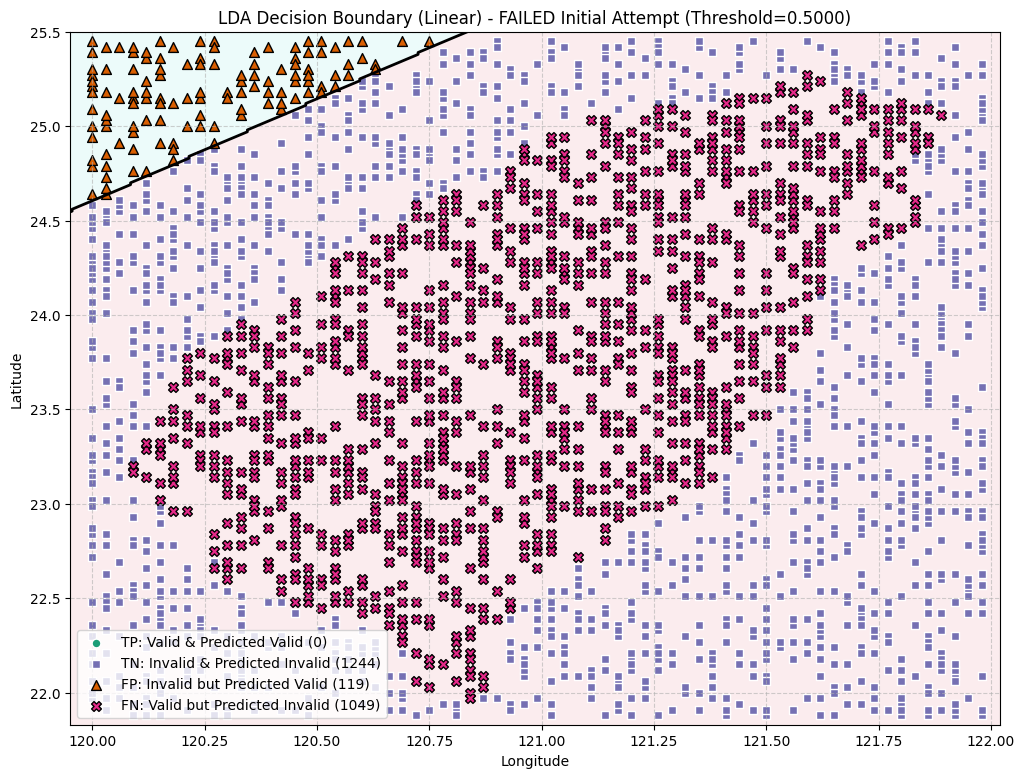

In [8]:
# --- CELL 7: PHASE 1: INITIAL ATTEMPT (LDA/Linear GDA) ---

print("\n" + "="*50)
print("PHASE 1: INITIAL GDA ATTEMPT (Linear Discriminant Analysis)")
print("="*50)

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, Y_train)
lda_default_accuracy = lda_model.calculate_accuracy(X_test, Y_test, threshold=0.5)
print(f"LDA Test Accuracy (Threshold 0.5000): {lda_default_accuracy:.4f}")

# Plot the poor performing LDA model
plot_confusion_visualization(lda_model, X_test, Y_test, X_class, 0.5, 
                             "LDA Decision Boundary (Linear) - FAILED Initial Attempt")

This is the result for the **GDA**, which gives the linear boundary. The performance is not good based on the model selection; it is assumed that two classes (`y` = 1 and `y` = 0) to have the same discrimination matrices, but in reality, it is not ture.

In [9]:
# --- CELL 8: PHASE 2: OPTIMIZED MODEL (QDA) - Default Threshold ---

print("\n" + "="*50)
print("PHASE 2: OPTIMIZED GDA (Quadratic Discriminant Analysis - QDA)")
print("="*50)

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, Y_train)


PHASE 2: OPTIMIZED GDA (Quadratic Discriminant Analysis - QDA)


QDA Test Accuracy (Threshold 0.5000): 0.8333

--- QDA Performance Across Varying Thresholds ---
Threshold  | Accuracy   | Precision  | Recall    
-----------------------------------------------
0.30       | 0.8122     | 0.7019     | 0.9876    
0.35       | 0.8346     | 0.7345     | 0.9704    
0.40       | 0.8416     | 0.7591     | 0.9314    
0.45       | 0.8375     | 0.7815     | 0.8694    
0.50       | 0.8333     | 0.8193     | 0.7912    
0.55       | 0.8329     | 0.9078     | 0.6854    
0.60       | 0.7923     | 0.9982     | 0.5234    
-----------------------------------------------


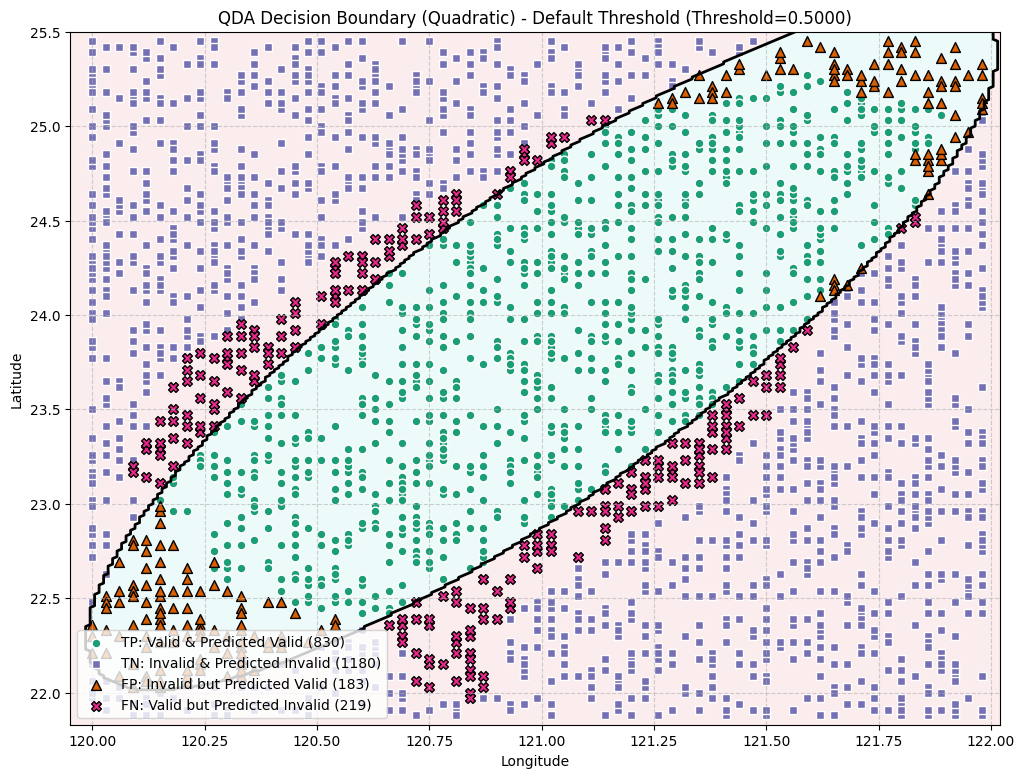

In [10]:
# --- LOGICAL CELL 9A: Threshold Sweep Evaluation and Visualization ---

# 1. Evaluate with default threshold (0.5)
qda_default_accuracy = qda_model.calculate_accuracy(X_test, Y_test, threshold=0.5)
print(f"QDA Test Accuracy (Threshold 0.5000): {qda_default_accuracy:.4f}")

# 2. Threshold Sweep Analysis: Generating the comprehensive performance table
print("\n--- QDA Performance Across Varying Thresholds ---")
# Test thresholds from 0.1 to 0.9
thresholds_to_test = np.linspace(0.30, 0.60, 7)
performance_data = []

# Get probabilities once to speed up the loop
Y_probs = qda_model.predict_proba(X_test)

for threshold in thresholds_to_test:
    # Predict based on current threshold
    Y_pred_sweep = (Y_probs >= threshold).astype(int)
    
    # Calculate metrics
    acc = accuracy_score(Y_test, Y_pred_sweep)
    prec = precision_score(Y_test, Y_pred_sweep, zero_division=0)
    rec = recall_score(Y_test, Y_pred_sweep, zero_division=0)
    
    performance_data.append([f'{threshold:.2f}', f'{acc:.4f}', f'{prec:.4f}', f'{rec:.4f}'])

# Print table header
print(f"{'Threshold':<10} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10}")
print("-" * 47)

# Print data rows
for row in performance_data:
    print(f"{row[0]:<10} | {row[1]:<10} | {row[2]:<10} | {row[3]:<10}")
print("-" * 47)

# 3. Plot the QDA decision boundary at the default threshold (0.5)
plot_confusion_visualization(qda_model, X_test, Y_test, X_class, 0.5, 
                             "QDA Decision Boundary (Quadratic) - Default Threshold")

QDA Test Accuracy (Threshold 0.5000): 0.8333


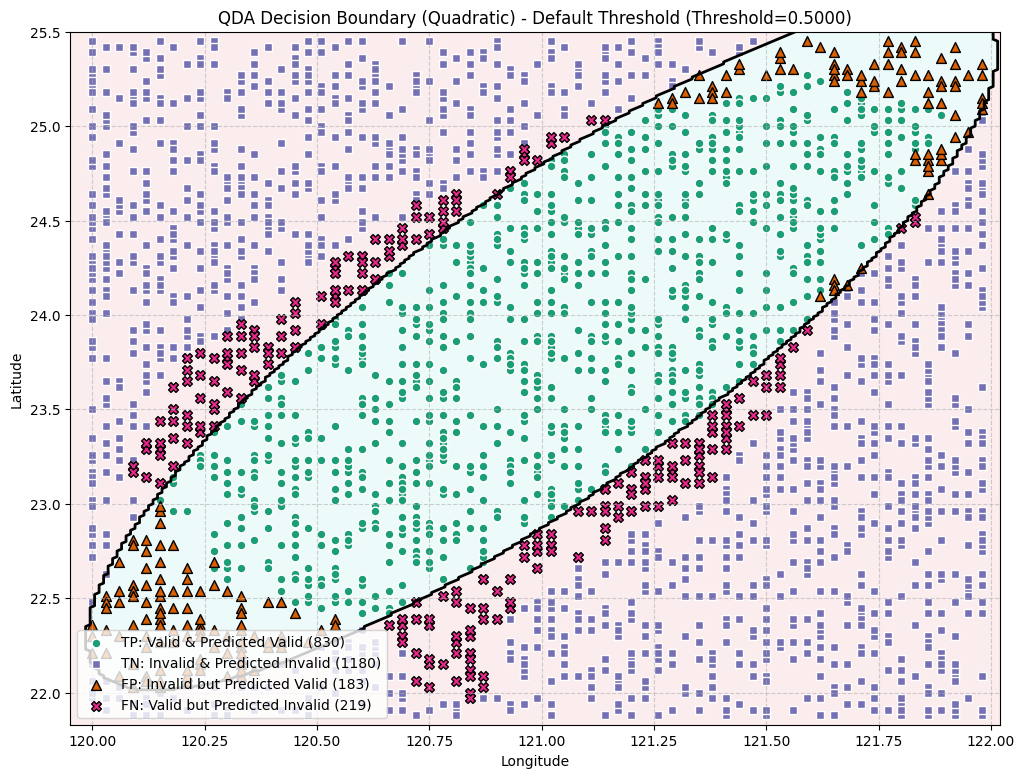


--- ROC ANALYSIS FOR QDA ---
AUC (Area Under Curve): 0.9420
Optimal Threshold (Youden's J Index): 0.3910


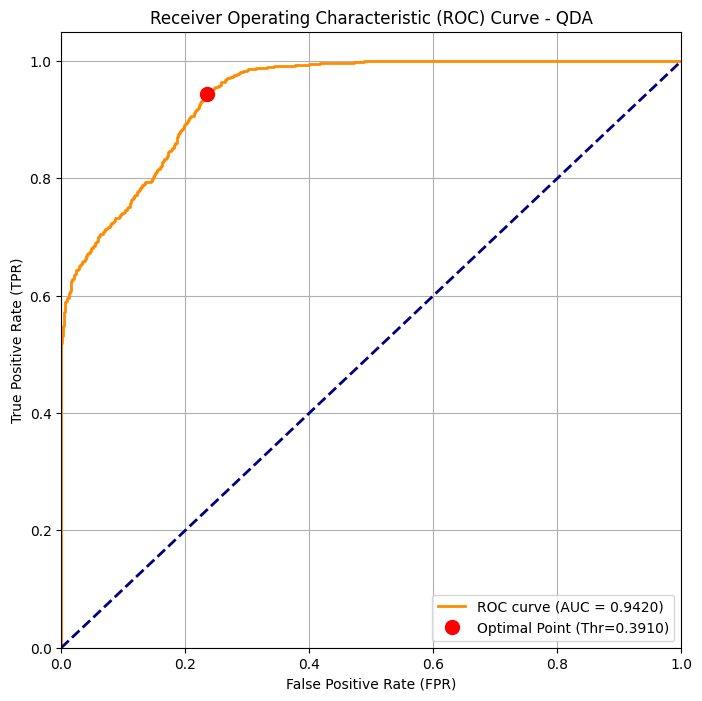


QDA Performance with Optimal Threshold (0.3910)
New Test Accuracy: 0.8425
Precision: 0.7551
Recall: 0.9438
F1-Score: 0.8390


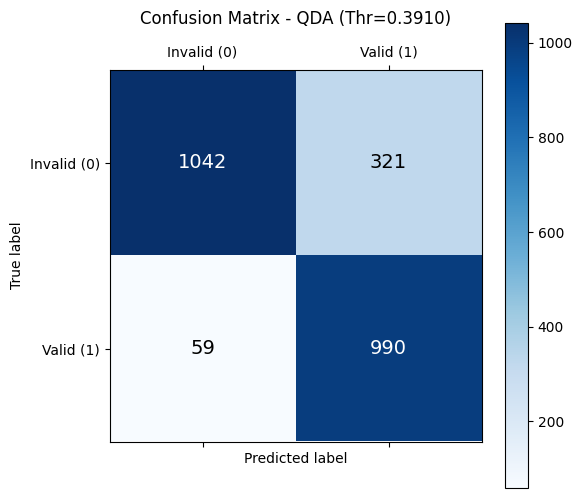

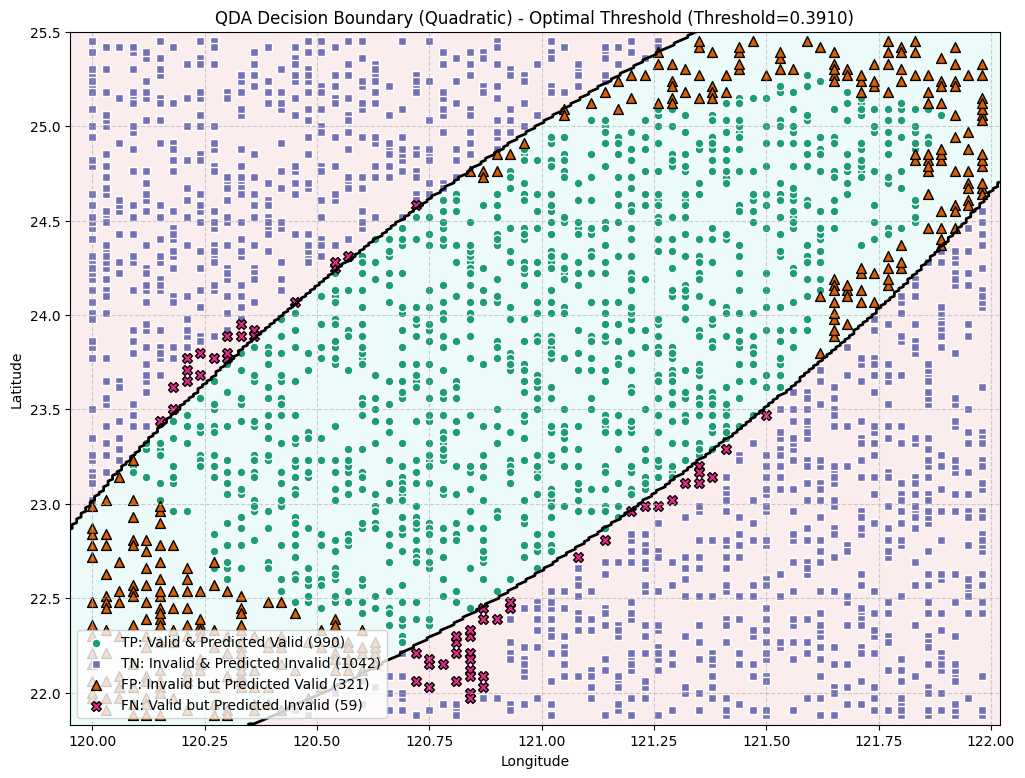

In [11]:
# --- CELL 9B: PHASE 2: OPTIMIZED MODEL (QDA) - ROC Analysis ---

# 1. Evaluate with default threshold (0.5)
qda_default_accuracy = qda_model.calculate_accuracy(X_test, Y_test, threshold=0.5)
print(f"QDA Test Accuracy (Threshold 0.5000): {qda_default_accuracy:.4f}")

# 2. Plot the QDA decision boundary at the default threshold
plot_confusion_visualization(qda_model, X_test, Y_test, X_class, 0.5, 
                             "QDA Decision Boundary (Quadratic) - Default Threshold")

# ROC Analysis and Optimal Threshold finding
optimal_threshold = plot_roc_and_find_optimal_threshold(qda_model, X_test, Y_test, "QDA")

# Evaluate with Optimal Threshold
qda_optimal_accuracy = qda_model.calculate_accuracy(X_test, Y_test, threshold=optimal_threshold)
print("\n" + "="*40)
print(f"QDA Performance with Optimal Threshold ({optimal_threshold:.4f})")
print(f"New Test Accuracy: {qda_optimal_accuracy:.4f}")

# 計算並輸出 Precision, Recall 和 F1-Score
Y_pred_optimal = qda_model.predict(X_test, threshold=optimal_threshold)
qda_precision = precision_score(Y_test, Y_pred_optimal)
qda_recall = recall_score(Y_test, Y_pred_optimal)
qda_f1 = f1_score(Y_test, Y_pred_optimal)

print(f"Precision: {qda_precision:.4f}")
print(f"Recall: {qda_recall:.4f}")
print(f"F1-Score: {qda_f1:.4f}")
print("="*40)

# 繪製混淆矩陣
plot_confusion_matrix(Y_test, Y_pred_optimal, "QDA", optimal_threshold)

# Plot QDA Results with optimal threshold
plot_confusion_visualization(qda_model, X_test, Y_test, X_class, optimal_threshold, 
                             "QDA Decision Boundary (Quadratic) - Optimal Threshold")

The result of the **GDA classification** and the **ROC Analysis** are shown above, the *threshold* is selected as 0.3910, detemined by *Youden index*, resulting precision 0.8425.


PHASE 3: LOGISTIC REGRESSION (For Loss Curve Demo)

Starting Logistic Regression Training (Iterative Model)...
  LR Iteration 100/500, Training Loss: 0.681581, Test Loss: 0.682840
  LR Iteration 200/500, Training Loss: 0.681493, Test Loss: 0.682834
  LR Iteration 300/500, Training Loss: 0.681492, Test Loss: 0.682841
  LR Iteration 400/500, Training Loss: 0.681492, Test Loss: 0.682842
  LR Iteration 500/500, Training Loss: 0.681492, Test Loss: 0.682842


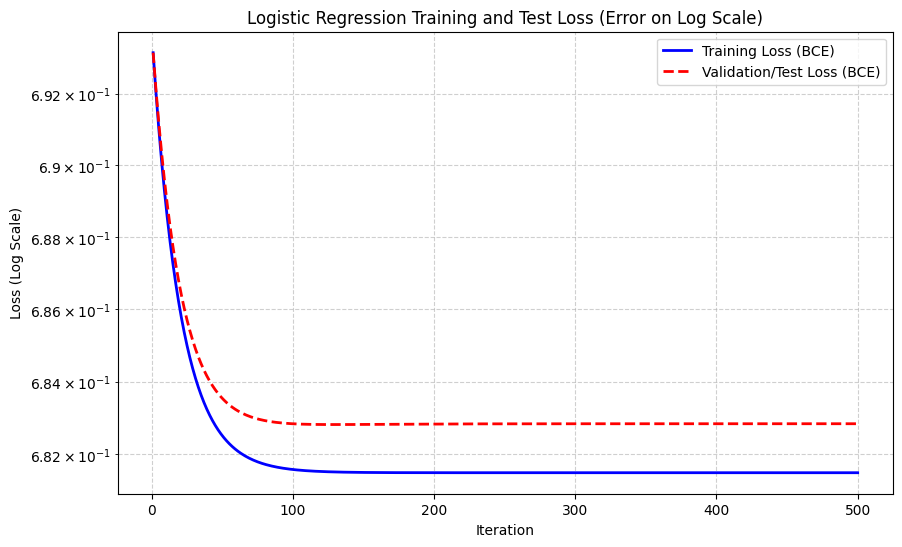

In [12]:
# --- CELL 10: PHASE 3: LOGISTIC REGRESSION (Loss Curve Demo) ---

print("\n" + "="*50)
print("PHASE 3: LOGISTIC REGRESSION (For Loss Curve Demo)")
print("="*50)

# 1. Standardize features for stable Gradient Descent
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_std[X_std == 0] = 1.0 

X_train_scaled = (X_train - X_mean) / X_std
# 2. 確保測試集使用訓練集的平均值和標準差進行標準化
X_test_scaled = (X_test - X_mean) / X_std 

lr_model = LogisticRegressionGD(learning_rate=0.1, n_iterations=500)

print("\nStarting Logistic Regression Training (Iterative Model)...")
# 3. 將訓練集和測試集都傳遞給 fit 函式
lr_model.fit(X_train_scaled, Y_train, X_test_scaled, Y_test)

# Plot the requested loss curve (Y-axis in Log Scale)
# 4. 傳遞兩組 Loss 歷史記錄以繪製兩條曲線
plot_loss_curve(lr_model.loss_history, lr_model.val_loss_history,
                title="Logistic Regression Training and Test Loss (Error on Log Scale)")

---

### Problem 2


--- PREPARING DATA FOR REGRESSION MODEL (R(x)) ---
Training regression on 3495 valid points.
Regression model fitted successfully.
Polynomial feature count: 21
Classification model refitted for combination.

--- APPLYING COMBINED MODEL OVER FULL GRID ---

--- VISUALIZING COMBINED MODEL OUTPUT ---


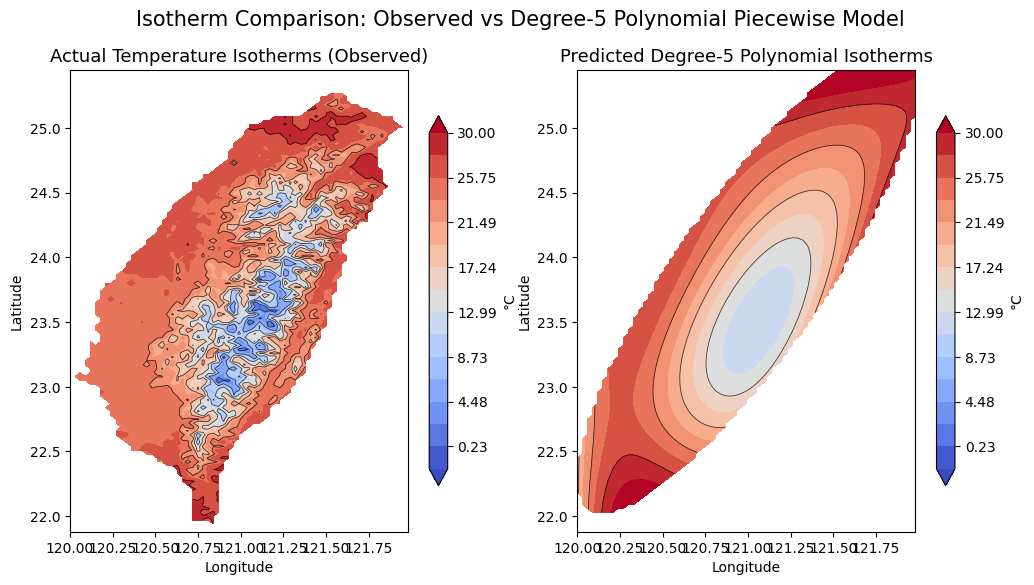


Valid points compared: 2745
MAE = 2.8800 °C
RMSE = 3.8399 °C


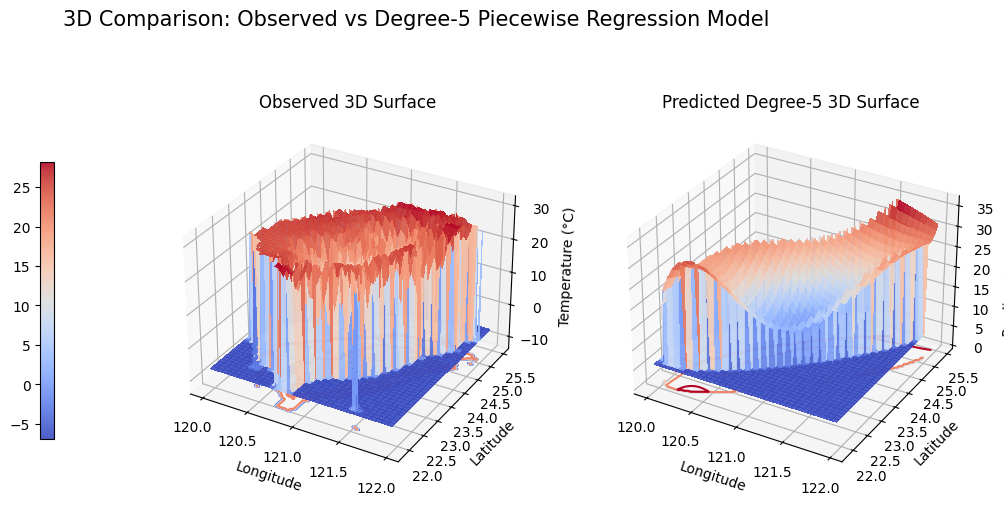

In [14]:
# ================================================================
# Problem 2: Piecewise Regression Model for Temperature Prediction
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# ======================================================================
# STEP 1. Build dataset for regression (only valid temperature points)
# ======================================================================
print("\n--- PREPARING DATA FOR REGRESSION MODEL (R(x)) ---")

valid_mask = temp_grid.ravel() != INVALID_VALUE
y_reg = temp_grid.ravel()[valid_mask]

# Coordinates corresponding to each temperature value
lat_count, lon_count = temp_grid.shape
lon_coords = LON_START + np.arange(lon_count) * RESOLUTION
lat_coords = LAT_START + np.arange(lat_count) * RESOLUTION
Lon_grid, Lat_grid = np.meshgrid(lon_coords, lat_coords)
X_reg_all = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
X_reg = X_reg_all[valid_mask]

print(f"Training regression on {X_reg.shape[0]} valid points.")

# ======================================================================
# STEP 2. Create polynomial features (easily adjustable degree)
# ======================================================================

POLY_DEGREE = 5   # <-- change this number to try different polynomial orders

poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=True)
X_poly = poly.fit_transform(X_reg)

# ======================================================================
# STEP 3. Train polynomial regression (least squares)
# ======================================================================

reg_model = LinearRegression()
reg_model.fit(X_poly, y_reg)

print("Regression model fitted successfully.")
print(f"Polynomial feature count: {X_poly.shape[1]}")

# ======================================================================
# STEP 4. Combine with classification model (C(x))
# ======================================================================

# Choose your preferred classifier; here we keep QDA as example
C_model = QuadraticDiscriminantAnalysis()
C_model.fit(X_train, Y_train)
print("Classification model refitted for combination.")

# ======================================================================
# STEP 5. Define combined hypothesis function h(x)
# ======================================================================

def combined_model_h(X_input):
    """
    Combined model:
        h(x) = R(x) if C(x) == 1
               INVALID_VALUE otherwise
    """
    X_poly_input = poly.transform(X_input)
    R_pred = reg_model.predict(X_poly_input)
    C_pred = C_model.predict(X_input)
    h_pred = np.where(C_pred == 1, R_pred, INVALID_VALUE)
    return h_pred

# ======================================================================
# STEP 6. Apply the combined model to the full coordinate grid
# ======================================================================
print("\n--- APPLYING COMBINED MODEL OVER FULL GRID ---")

X_full = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
h_pred_full = combined_model_h(X_full)
h_pred_grid = h_pred_full.reshape(lat_count, lon_count)

# ======================================================================
# STEP 7. Visualization (same 3D and contour style as Homework 4)
# ======================================================================
print("\n--- VISUALIZING COMBINED MODEL OUTPUT ---")

# Observed (actual) grid for comparison
obs_grid = np.where(temp_grid == INVALID_VALUE, np.nan, temp_grid)
pred_display = np.where(h_pred_grid == INVALID_VALUE, np.nan, h_pred_grid)

# Compute plotting range
vmin = np.nanmin(obs_grid)
vmax = np.nanmax(obs_grid)
levels = np.linspace(vmin, vmax, 16)

# --- 2D Isotherm Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

c0 = axes[0].contourf(Lon_grid, Lat_grid, obs_grid, levels=levels, cmap="coolwarm", extend='both')
axes[0].contour(Lon_grid, Lat_grid, obs_grid, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[0].set_title("Actual Temperature Isotherms (Observed)", fontsize=13)
axes[0].set_xlabel("Longitude"); axes[0].set_ylabel("Latitude")
fig.colorbar(c0, ax=axes[0], shrink=0.8, label="°C")

c1 = axes[1].contourf(Lon_grid, Lat_grid, pred_display, levels=levels, cmap="coolwarm", extend='both')
axes[1].contour(Lon_grid, Lat_grid, pred_display, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[1].set_title(f"Predicted Degree-{POLY_DEGREE} Polynomial Isotherms", fontsize=13)
axes[1].set_xlabel("Longitude"); axes[1].set_ylabel("Latitude")
fig.colorbar(c1, ax=axes[1], shrink=0.8, label="°C")

plt.suptitle(f"Isotherm Comparison: Observed vs Degree-{POLY_DEGREE} Polynomial Piecewise Model", fontsize=15)
plt.show()

# --- Error Metrics ---
mask_valid = ~np.isnan(obs_grid) & ~np.isnan(pred_display)
if mask_valid.any():
    diff = pred_display[mask_valid] - obs_grid[mask_valid]
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    print(f"\nValid points compared: {mask_valid.sum()}")
    print(f"MAE = {mae:.4f} °C")
    print(f"RMSE = {rmse:.4f} °C")
else:
    print("\nNo overlapping valid points for error metrics.")

# --- 3D Surface Visualization (Homework 4 style) ---
fill_obs = np.nanmin(obs_grid) - 5.0
fill_pred = np.nanmin(pred_display[np.isfinite(pred_display)]) - 5.0
obs_surface = np.nan_to_num(obs_grid, nan=fill_obs)
pred_surface = np.nan_to_num(pred_display, nan=fill_pred)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(Lon_grid, Lat_grid, obs_surface, cmap='coolwarm',
                         linewidth=0, antialiased=False, alpha=0.9)
ax1.contour(Lon_grid, Lat_grid, obs_surface, zdir='z', offset=np.min(obs_surface)-6,
            levels=levels[::3], cmap='coolwarm')
ax1.set_title("Observed 3D Surface", fontsize=12)
ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude"); ax1.set_zlabel("Temperature (°C)")
ax1.set_zlim(np.min(obs_surface)-6, np.max(obs_surface)+2)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(Lon_grid, Lat_grid, pred_surface, cmap='coolwarm',
                         linewidth=0, antialiased=False, alpha=0.9)
ax2.contour(Lon_grid, Lat_grid, pred_surface, zdir='z', offset=np.min(pred_surface)-6,
            levels=levels[::3], cmap='coolwarm')
ax2.set_title(f"Predicted Degree-{POLY_DEGREE} 3D Surface", fontsize=12)
ax2.set_xlabel("Longitude"); ax2.set_ylabel("Latitude"); ax2.set_zlabel("Predicted Temp (°C)")
ax2.set_zlim(np.min(pred_surface)-6, np.max(pred_surface)+2)

fig.colorbar(surf1, ax=[ax1, ax2], shrink=0.6, aspect=20, location='left')
plt.suptitle(f"3D Comparison: Observed vs Degree-{POLY_DEGREE} Piecewise Regression Model", fontsize=15)
plt.show()



--- PREPARING DATA FOR REGRESSION MODEL (R(x)) ---
Total valid points for regression: 3495
Training set size: 2796
Validation set size: 699
Regression model fitted successfully.
Polynomial feature count: 21

--- REGRESSION VALIDATION LOSS ---
Validation MSE: 12.8496
Validation R²: 0.6212
Classification model refitted for combination.

--- APPLYING COMBINED MODEL OVER FULL GRID ---

--- VISUALIZING COMBINED MODEL OUTPUT ---


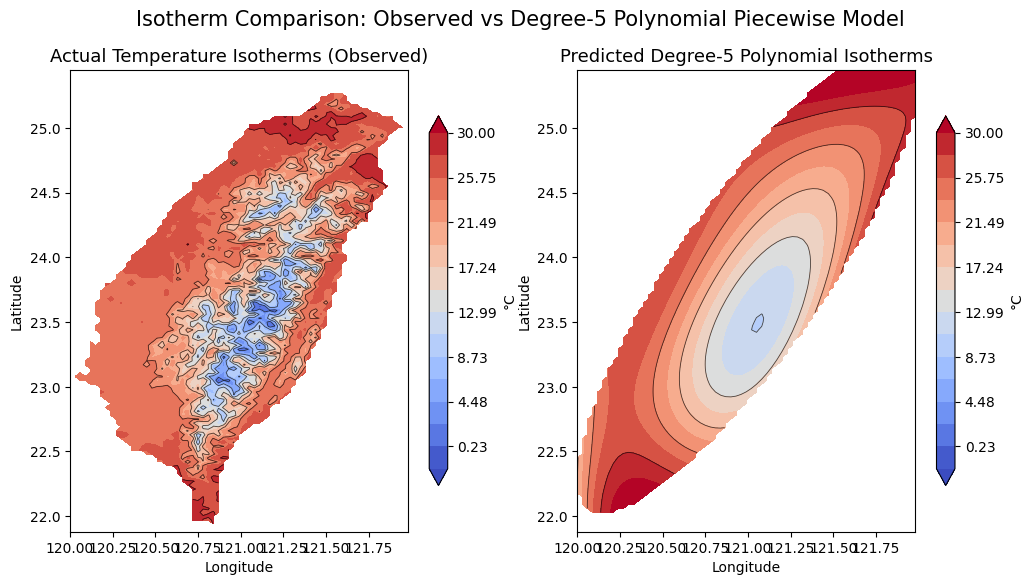


Valid points compared: 2745
MAE = 2.8929 °C
RMSE = 3.8410 °C


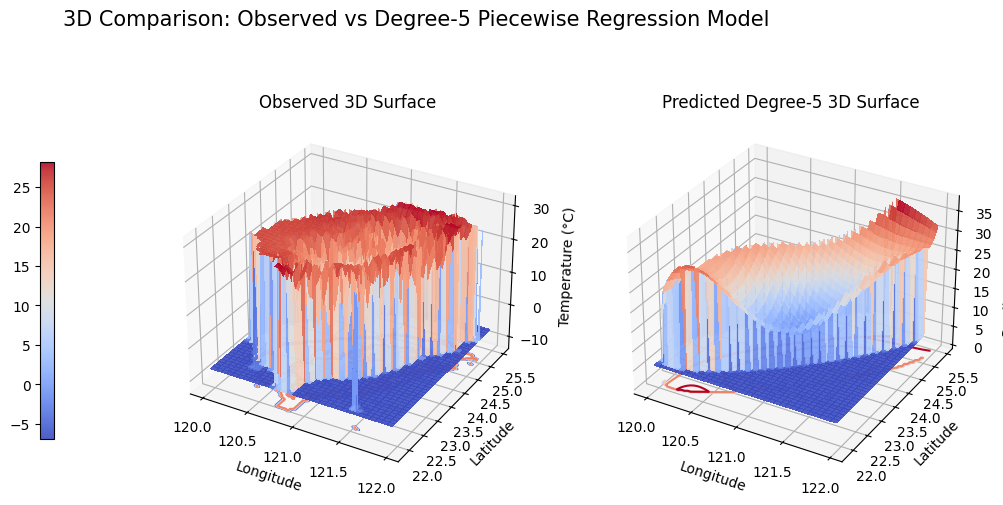

In [15]:
# ================================================================
# Problem 2: Piecewise Regression Model for Temperature Prediction
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split # <--- ADDED for splitting
from sklearn.metrics import mean_squared_error, r2_score # <--- ADDED for loss calculation

# Assume temp_grid, LON_START, LAT_START, RESOLUTION, INVALID_VALUE, X_train, Y_train are defined earlier

# ======================================================================
# STEP 1. Build dataset for regression (only valid temperature points)
# ======================================================================
print("\n--- PREPARING DATA FOR REGRESSION MODEL (R(x)) ---")

valid_mask = temp_grid.ravel() != INVALID_VALUE
y_reg = temp_grid.ravel()[valid_mask]

# Coordinates corresponding to each temperature value
lat_count, lon_count = temp_grid.shape
lon_coords = LON_START + np.arange(lon_count) * RESOLUTION
lat_coords = LAT_START + np.arange(lat_count) * RESOLUTION
Lon_grid, Lat_grid = np.meshgrid(lon_coords, lat_coords)
X_reg_all = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
X_reg = X_reg_all[valid_mask]

print(f"Total valid points for regression: {X_reg.shape[0]}")

# ADDED: Split the regression data into training and validation sets
X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# ADDED: Print the number of data in the training and validation set
print(f"Training set size: {X_reg_train.shape[0]}")
print(f"Validation set size: {X_reg_val.shape[0]}")


# ======================================================================
# STEP 2. Create polynomial features (easily adjustable degree)
# ======================================================================

POLY_DEGREE = 5  # <-- change this number to try different polynomial orders

poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=True)
X_poly_train = poly.fit_transform(X_reg_train) # <--- Train on training features
X_poly_val = poly.transform(X_reg_val)       # <--- Transform validation features

# ======================================================================
# STEP 3. Train polynomial regression (least squares)
# ======================================================================

reg_model = LinearRegression()
reg_model.fit(X_poly_train, y_reg_train) # <--- Train on training data

print("Regression model fitted successfully.")
print(f"Polynomial feature count: {X_poly_train.shape[1]}")

# ADDED: Calculate and print validation loss
y_reg_val_pred = reg_model.predict(X_poly_val)
val_mse = mean_squared_error(y_reg_val, y_reg_val_pred)
val_r2 = r2_score(y_reg_val, y_reg_val_pred)

print("\n--- REGRESSION VALIDATION LOSS ---")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R²: {val_r2:.4f}")


# ======================================================================
# STEP 4. Combine with classification model (C(x))
# ======================================================================

# Choose your preferred classifier; here we keep QDA as example
C_model = QuadraticDiscriminantAnalysis()
C_model.fit(X_train, Y_train) # Assumes X_train, Y_train are the full classification training sets
print("Classification model refitted for combination.")

# ======================================================================
# STEP 5. Define combined hypothesis function h(x)
# ======================================================================

def combined_model_h(X_input):
    """
    Combined model:
        h(x) = R(x) if C(x) == 1
             INVALID_VALUE otherwise
    """
    X_poly_input = poly.transform(X_input)
    R_pred = reg_model.predict(X_poly_input)
    C_pred = C_model.predict(X_input)
    h_pred = np.where(C_pred == 1, R_pred, INVALID_VALUE)
    return h_pred

# ======================================================================
# STEP 6. Apply the combined model to the full coordinate grid
# ======================================================================
print("\n--- APPLYING COMBINED MODEL OVER FULL GRID ---")

X_full = np.vstack([Lon_grid.ravel(), Lat_grid.ravel()]).T
h_pred_full = combined_model_h(X_full)
h_pred_grid = h_pred_full.reshape(lat_count, lon_count)

# ======================================================================
# STEP 7. Visualization (same 3D and contour style as Homework 4)
# ======================================================================
print("\n--- VISUALIZING COMBINED MODEL OUTPUT ---")

# Observed (actual) grid for comparison
obs_grid = np.where(temp_grid == INVALID_VALUE, np.nan, temp_grid)
pred_display = np.where(h_pred_grid == INVALID_VALUE, np.nan, h_pred_grid)

# Compute plotting range
vmin = np.nanmin(obs_grid)
vmax = np.nanmax(obs_grid)
levels = np.linspace(vmin, vmax, 16)

# --- 2D Isotherm Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

c0 = axes[0].contourf(Lon_grid, Lat_grid, obs_grid, levels=levels, cmap="coolwarm", extend='both')
axes[0].contour(Lon_grid, Lat_grid, obs_grid, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[0].set_title("Actual Temperature Isotherms (Observed)", fontsize=13)
axes[0].set_xlabel("Longitude"); axes[0].set_ylabel("Latitude")
fig.colorbar(c0, ax=axes[0], shrink=0.8, label="°C")

c1 = axes[1].contourf(Lon_grid, Lat_grid, pred_display, levels=levels, cmap="coolwarm", extend='both')
axes[1].contour(Lon_grid, Lat_grid, pred_display, levels=levels[::2], colors='k', linewidths=0.6, alpha=0.7)
axes[1].set_title(f"Predicted Degree-{POLY_DEGREE} Polynomial Isotherms", fontsize=13)
axes[1].set_xlabel("Longitude"); axes[1].set_ylabel("Latitude")
fig.colorbar(c1, ax=axes[1], shrink=0.8, label="°C")

plt.suptitle(f"Isotherm Comparison: Observed vs Degree-{POLY_DEGREE} Polynomial Piecewise Model", fontsize=15)
plt.show()

# --- Error Metrics ---
mask_valid = ~np.isnan(obs_grid) & ~np.isnan(pred_display)
if mask_valid.any():
    diff = pred_display[mask_valid] - obs_grid[mask_valid]
    mae = np.mean(np.abs(diff))
    rmse = np.sqrt(np.mean(diff**2))
    print(f"\nValid points compared: {mask_valid.sum()}")
    print(f"MAE = {mae:.4f} °C")
    print(f"RMSE = {rmse:.4f} °C")
else:
    print("\nNo overlapping valid points for error metrics.")

# --- 3D Surface Visualization (Homework 4 style) ---
fill_obs = np.nanmin(obs_grid) - 5.0
fill_pred = np.nanmin(pred_display[np.isfinite(pred_display)]) - 5.0
obs_surface = np.nan_to_num(obs_grid, nan=fill_obs)
pred_surface = np.nan_to_num(pred_display, nan=fill_pred)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(Lon_grid, Lat_grid, obs_surface, cmap='coolwarm',
                         linewidth=0, antialiased=False, alpha=0.9)
ax1.contour(Lon_grid, Lat_grid, obs_surface, zdir='z', offset=np.min(obs_surface)-6,
            levels=levels[::3], cmap='coolwarm')
ax1.set_title("Observed 3D Surface", fontsize=12)
ax1.set_xlabel("Longitude"); ax1.set_ylabel("Latitude"); ax1.set_zlabel("Temperature (°C)")
ax1.set_zlim(np.min(obs_surface)-6, np.max(obs_surface)+2)

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(Lon_grid, Lat_grid, pred_surface, cmap='coolwarm',
                         linewidth=0, antialiased=False, alpha=0.9)
ax2.contour(Lon_grid, Lat_grid, pred_surface, zdir='z', offset=np.min(pred_surface)-6,
            levels=levels[::3], cmap='coolwarm')
ax2.set_title(f"Predicted Degree-{POLY_DEGREE} 3D Surface", fontsize=12)
ax2.set_xlabel("Longitude"); ax2.set_ylabel("Latitude"); ax2.set_zlabel("Predicted Temp (°C)")
ax2.set_zlim(np.min(pred_surface)-6, np.max(pred_surface)+2)

fig.colorbar(surf1, ax=[ax1, ax2], shrink=0.6, aspect=20, location='left')
plt.suptitle(f"3D Comparison: Observed vs Degree-{POLY_DEGREE} Piecewise Regression Model", fontsize=15)
plt.show()

Compare the isotherm plots and 3D surfaces for different polynomial degrees (e.g., 2, 3, 5, 7) to observe how the model complexity affects the fit to the observed temperature data.


Training samples: 2796, Testing samples: 699

--- Neural Network Regression Experiments ---
Activation=relu    | Optimizer=adam  | MSE=34.269 | R²=-0.0102
Activation=relu    | Optimizer=lbfgs | MSE=29.557 | R²=0.1287
Activation=tanh    | Optimizer=adam  | MSE=34.206 | R²=-0.0083
Activation=tanh    | Optimizer=lbfgs | MSE=24.943 | R²=0.2647
Activation=logistic | Optimizer=adam  | MSE=34.208 | R²=-0.0084


c:\Users\benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation=logistic | Optimizer=lbfgs | MSE=25.560 | R²=0.2465

Best NN: Activation=tanh, Optimizer=lbfgs with MSE=24.943, R²=0.2647


c:\Users\benny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



XGBoost | MSE=22.725 | R²=0.3301
CatBoost | MSE=6.395 | R²=0.8115

🏆 Best Performing Model: CatBoost | MSE=6.395 | R²=0.8115

--- APPLYING BEST MODEL OVER FULL GRID ---


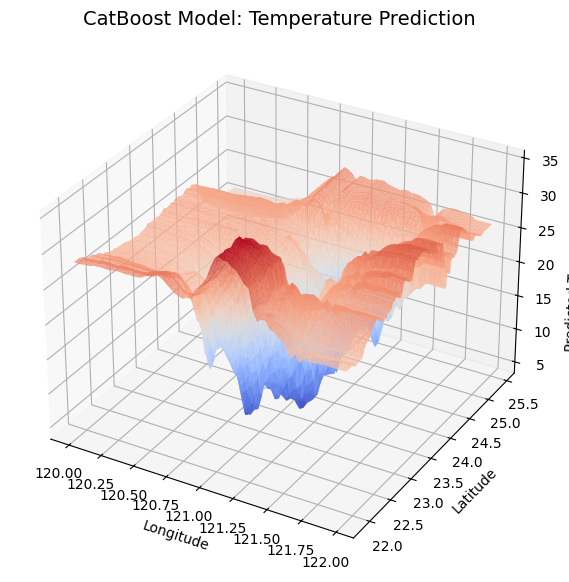

In [16]:
# ================================================================
# Problem 3: Advanced Regression Models for Temperature Prediction
# ================================================================
# Goal: Test if we can outperform the degree-4 polynomial regression
# by trying modern nonlinear models (Neural Network, XGBoost, CatBoost)
# and compare their performances under different activations/optimizers.

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === STEP 1: Split data for fair evaluation ===
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train_reg)}, Testing samples: {len(X_test_reg)}")

# =======================================================
# Model 1: Neural Network Regressor (MLPRegressor, sklearn)
# =======================================================
from sklearn.neural_network import MLPRegressor

activations = ["relu", "tanh", "logistic"]
optimizers = ["adam", "lbfgs"]

nn_results = {}

print("\n--- Neural Network Regression Experiments ---")
for act in activations:
    for opt in optimizers:
        nn_model = MLPRegressor(
            hidden_layer_sizes=(128, 64, 32),
            activation=act,
            solver=opt,
            max_iter=2000,
            random_state=42
        )
        nn_model.fit(X_train_reg, y_train_reg)
        y_pred_nn = nn_model.predict(X_test_reg)
        mse = mean_squared_error(y_test_reg, y_pred_nn)
        r2 = r2_score(y_test_reg, y_pred_nn)
        nn_results[(act, opt)] = (mse, r2)
        print(f"Activation={act:<7} | Optimizer={opt:<5} | MSE={mse:.3f} | R²={r2:.4f}")

# Pick the best NN model
best_nn_cfg = min(nn_results, key=lambda x: nn_results[x][0])
print(f"\nBest NN: Activation={best_nn_cfg[0]}, Optimizer={best_nn_cfg[1]} "
      f"with MSE={nn_results[best_nn_cfg][0]:.3f}, R²={nn_results[best_nn_cfg][1]:.4f}")

best_nn_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation=best_nn_cfg[0],
    solver=best_nn_cfg[1],
    max_iter=2000,
    random_state=42
)
best_nn_model.fit(X_reg, y_reg)

# =======================================================
# Model 2: XGBoost Regressor
# =======================================================
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
xgb_model.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_model.predict(X_test_reg)
mse_xgb = mean_squared_error(y_test_reg, y_pred_xgb)
r2_xgb = r2_score(y_test_reg, y_pred_xgb)
print(f"\nXGBoost | MSE={mse_xgb:.3f} | R²={r2_xgb:.4f}")

# =======================================================
# Model 3: CatBoost Regressor
# =======================================================
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=False,
    random_seed=42
)
cat_model.fit(X_train_reg, y_train_reg)
y_pred_cat = cat_model.predict(X_test_reg)
mse_cat = mean_squared_error(y_test_reg, y_pred_cat)
r2_cat = r2_score(y_test_reg, y_pred_cat)
print(f"CatBoost | MSE={mse_cat:.3f} | R²={r2_cat:.4f}")

# =======================================================
# STEP 4: Choose best model and visualize predictions
# =======================================================
model_performance = {
    "NeuralNet": nn_results[best_nn_cfg],
    "XGBoost": (mse_xgb, r2_xgb),
    "CatBoost": (mse_cat, r2_cat)
}

best_model_name = min(model_performance, key=lambda k: model_performance[k][0])
print(f"\n🏆 Best Performing Model: {best_model_name} "
      f"| MSE={model_performance[best_model_name][0]:.3f} "
      f"| R²={model_performance[best_model_name][1]:.4f}")

# Pick the corresponding trained model
if best_model_name == "NeuralNet":
    final_reg_model = best_nn_model
elif best_model_name == "XGBoost":
    final_reg_model = xgb_model
else:
    final_reg_model = cat_model

# =======================================================
# STEP 5: Apply the best model on the full grid and visualize
# =======================================================
print("\n--- APPLYING BEST MODEL OVER FULL GRID ---")
R_pred_full = final_reg_model.predict(X_full)
R_pred_grid = R_pred_full.reshape(lat_count, lon_count)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(
    X_full[:, 0],
    X_full[:, 1],
    R_pred_full,
    cmap='coolwarm',
    linewidth=0.2,
    alpha=0.9
)

ax.set_title(f"{best_model_name} Model: Temperature Prediction", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Predicted Temperature (°C)")
plt.show()


Compare all the neural network models and futher the boosting model, we see that running this cell take around 4 min, mainly spent on the boosting. The most precised model-- CatBoost is found in this cell too. 

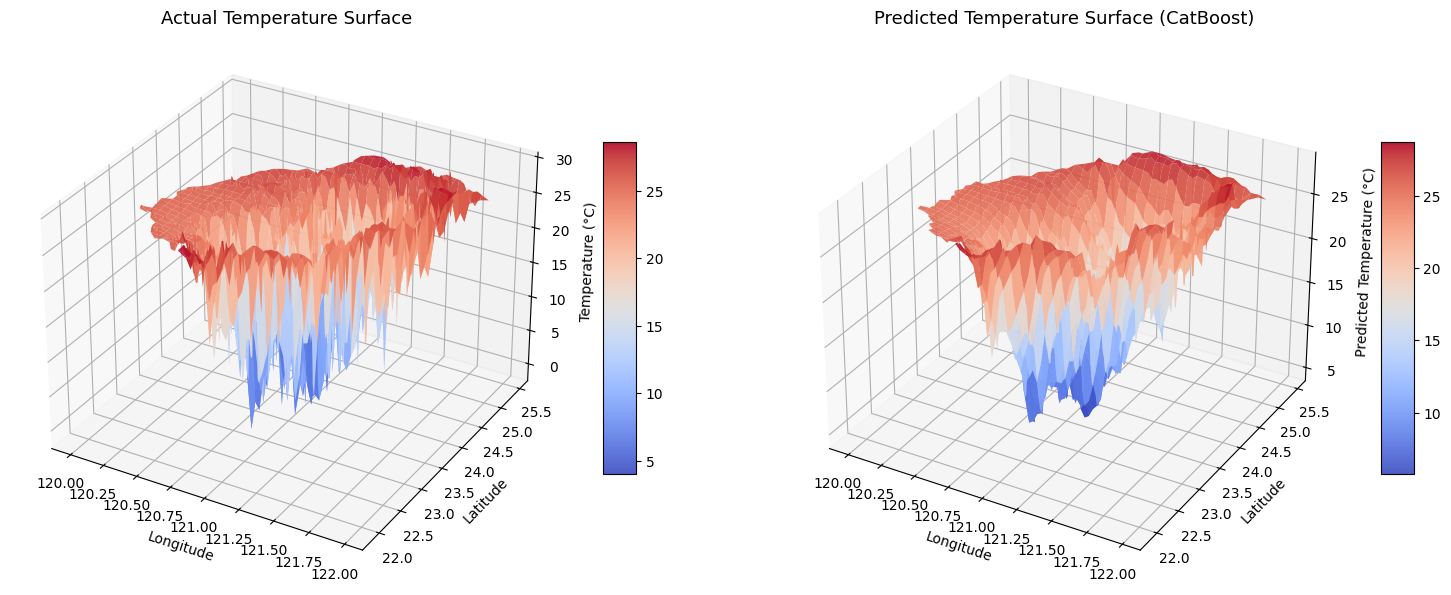

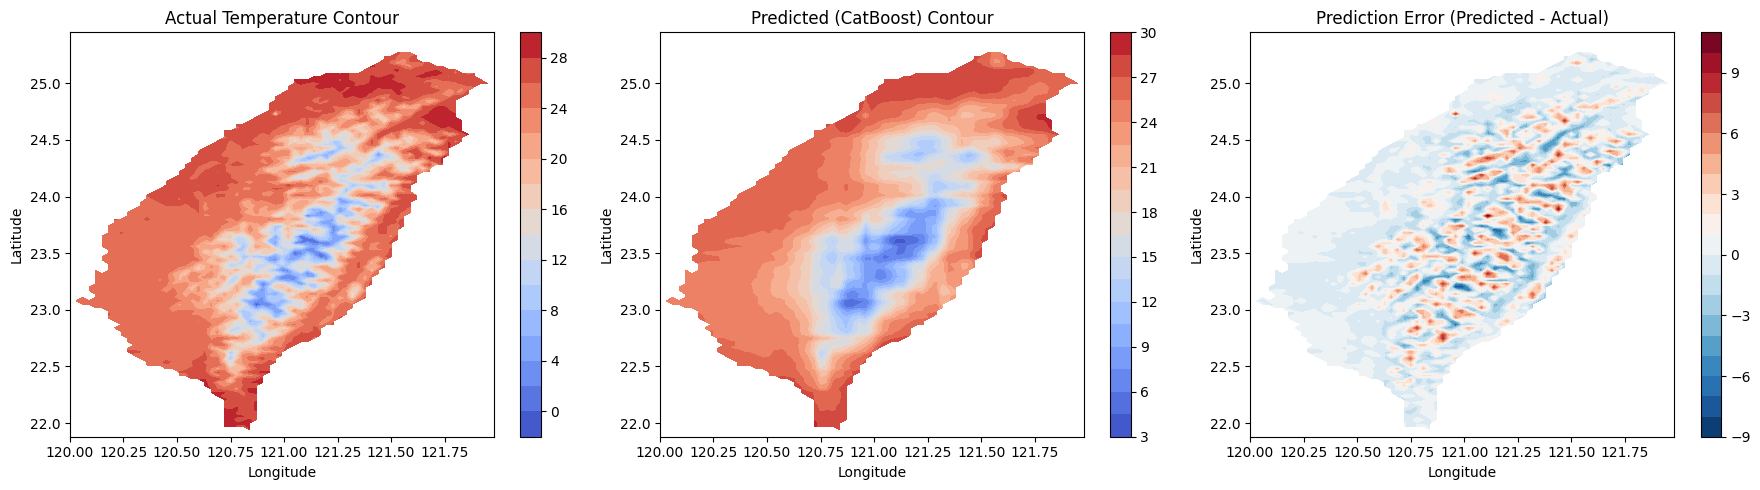


--- MODEL PERFORMANCE SUMMARY ---
Model: CatBoost
Mean Squared Error (MSE): 4.8553
Mean Absolute Error (MAE): 1.5115
R² Score (grid-level): 0.8713


In [17]:
# ================================================================
# Problem 4: Visualization & Comparison with Actual Temperature
# ================================================================

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# === STEP 1: Prepare coordinate grid ===
X_mesh = Lon_grid
Y_mesh = Lat_grid
Z_true = temp_grid
Z_pred = R_pred_grid  # from best model in Problem 3

# Mask invalid values
valid_mask_vis = Z_true != INVALID_VALUE
Z_true_vis = np.where(valid_mask_vis, Z_true, np.nan)
Z_pred_vis = np.where(valid_mask_vis, Z_pred, np.nan)

# =======================================================
# STEP 2: 3D Surface Comparison
# =======================================================
fig = plt.figure(figsize=(16, 6))

# --- Actual ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(
    X_mesh, Y_mesh, Z_true_vis,
    cmap='coolwarm', edgecolor='none', alpha=0.9
)
ax1.set_title("Actual Temperature Surface", fontsize=13)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax1.set_zlabel("Temperature (°C)")
fig.colorbar(surf1, ax=ax1, shrink=0.6, aspect=10)

# --- Predicted ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(
    X_mesh, Y_mesh, Z_pred_vis,
    cmap='coolwarm', edgecolor='none', alpha=0.9
)
ax2.set_title(f"Predicted Temperature Surface ({best_model_name})", fontsize=13)
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")
ax2.set_zlabel("Predicted Temperature (°C)")
fig.colorbar(surf2, ax=ax2, shrink=0.6, aspect=10)

plt.tight_layout()
plt.show()

# =======================================================
# STEP 3: 2D Contour Comparison
# =======================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Actual contour ---
cont1 = axes[0].contourf(
    X_mesh, Y_mesh, Z_true_vis,
    levels=20, cmap='coolwarm'
)
axes[0].set_title("Actual Temperature Contour")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
fig.colorbar(cont1, ax=axes[0])

# --- Predicted contour ---
cont2 = axes[1].contourf(
    X_mesh, Y_mesh, Z_pred_vis,
    levels=20, cmap='coolwarm'
)
axes[1].set_title(f"Predicted ({best_model_name}) Contour")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
fig.colorbar(cont2, ax=axes[1])

# --- Difference map (error) ---
error_map = Z_pred_vis - Z_true_vis
cont3 = axes[2].contourf(
    X_mesh, Y_mesh, error_map,
    levels=20, cmap='RdBu_r'
)
axes[2].set_title("Prediction Error (Predicted - Actual)")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")
fig.colorbar(cont3, ax=axes[2])

plt.tight_layout()
plt.show()

# =======================================================
# STEP 4: Summary statistics
# =======================================================
import numpy as np
valid_errors = error_map[~np.isnan(error_map)]
mse_final = np.mean(valid_errors**2)
mae_final = np.mean(np.abs(valid_errors))
r2_final = 1 - np.sum(valid_errors**2) / np.sum((Z_true_vis[~np.isnan(Z_true_vis)] - np.nanmean(Z_true_vis))**2)

print("\n--- MODEL PERFORMANCE SUMMARY ---")
print(f"Model: {best_model_name}")
print(f"Mean Squared Error (MSE): {mse_final:.4f}")
print(f"Mean Absolute Error (MAE): {mae_final:.4f}")
print(f"R² Score (grid-level): {r2_final:.4f}")


Plot the overall best model comparing to the actual temperature distribution, which yields a very close result.